In [1]:
import pandas as pd
import csv
from pathlib import Path
import json
import numpy as np
from datetime import datetime
import time
import os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import plotly.graph_objects as go

In [2]:
root_path = Path('/Users/ycchen/Desktop/IORG工作/DA_no24/data_input')
out_path = Path('/Users/ycchen/Desktop/IORG工作/DA_no24/data_output')
pic_path = Path('/Users/ycchen/Desktop/IORG工作/DA_no24/data_output/pic')

In [3]:
label_data = []
with open(out_path/'v2_cofacts_clustering_20220322-20220422.json' , 'r', encoding='big5') as reader:
    data = json.loads(reader.read())
    for idx, reply in enumerate(data):
#         print(data[idx])
        label_data.append([
            data[idx]['label'],
            data[idx]['size'],
            data[idx]['article_id'],
            data[idx]['covid'],
            data[idx]['coexist'],
            data[idx]['contains_url'],
            data[idx]['contains_url_format'],
            data[idx]['text'],
            data[idx]['clean_segment']
        ])

In [4]:
columns = ['label', 'size', 'article_id', 'covid', 'coexist',
           'contains_url', 'contains_url_format', 'text', 'clean_segment']
label_data_df = pd.DataFrame(label_data, columns=columns)

In [5]:
article_truth_score_merge = pd.read_csv(out_path/'cofacts_truth_score_merge_20220322-20220422.csv')

In [6]:
label_data_df = article_truth_score_merge[['article_id', 'article_type_prop']].merge(label_data_df)

In [7]:
label_data_df = label_data_df[label_data_df.article_type_prop=='謠言或個人意見']

In [8]:
label_data_df.shape

(7008, 10)

# general by post
## 有被瀏覽或查詢

In [9]:
#資料筆數、回報次數
cofacts_rumor_count = len(label_data_df)
covid_rumor_count = len(label_data_df[label_data_df.covid=='yes'])
coexist_rumor_count = len(label_data_df[label_data_df.coexist=='yes'])
print(cofacts_rumor_count, covid_rumor_count, coexist_rumor_count)

7008 1927 16


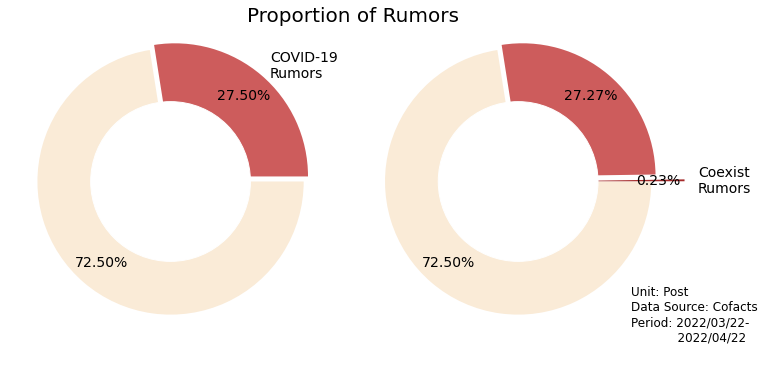

In [10]:
plt.figure(figsize=(12,6), facecolor='white', edgecolor='white')
plt.suptitle('Proportion of Rumors', fontsize=20, y=0.95)
plt.subplots_adjust(left = 0.1, bottom = 0.2, right = 0.9, top = 0.9, wspace = 0.1, hspace = 0.1)

#left fig
plt.subplot(121)

size_of_groups=[cofacts_rumor_count-covid_rumor_count, covid_rumor_count]
# Create a pie plot
separated = (0, .05)
colors = ['antiquewhite', 'indianred']
labels = ['','COVID-19\nRumors']
plt.pie(size_of_groups, counterclock=False, textprops = {"fontsize" : 14},
        autopct = "%1.2f%%", pctdistance=0.8,
        explode=separated, colors=colors, labels=labels)

# add a white circle at the center
my_circle=plt.Circle((0,0), 0.6, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.axis('equal')

#right fig
plt.subplot(122)

size_of_groups=[cofacts_rumor_count-covid_rumor_count, covid_rumor_count-coexist_rumor_count, coexist_rumor_count]
# Create a pie plot
separated = (0, .05, .25)
colors = ['antiquewhite', 'indianred', 'brown']
labels = ['','','Coexist\nRumors']
plt.pie(size_of_groups, counterclock=False, 
        autopct = "%1.2f%%", pctdistance=0.8, textprops = {"fontsize" : 14},
        explode=separated, colors=colors, labels=labels)
# add a white circle at the center
my_circle=plt.Circle((0,0), 0.6, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.axis('equal')

plt.annotate('Unit: Post\nData Source: Cofacts\nPeriod: 2022/03/22-\n            2022/04/22', 
             (0.73,0.1), xycoords='figure fraction', fontsize=12)

save_name = 'Proportion of Rumors'
plt.savefig(pic_path/f'cofacts_{save_name}_by_post_circle.png', 
            bbox_inches='tight') # 去除座標軸占用的空間

plt.show()

# covid_owd_statistics

In [11]:
covid_owd_statistics = pd.read_csv(root_path/'covid_owd_statistics.csv')

In [12]:
taiwan_covid_owd_statistics = covid_owd_statistics[covid_owd_statistics['location']=='Taiwan']
taiwan = taiwan_covid_owd_statistics[['location', 'date', 'total_cases', 'new_cases', 'total_deaths', 'new_deaths']]

In [13]:
taiwan = taiwan[taiwan['date'] >= '2022-03-22']
taiwan = taiwan[taiwan['date'] <= '2022-04-22']

# define new/old rumor

In [14]:
# "data" are all sheets as a dictionary
data = pd.read_excel(root_path/'cofacts_20220322-20220422_20220503dump.xlsx', sheet_name = None) 
xls = pd.ExcelFile(root_path/'cofacts_20220322-20220422_20220503dump.xlsx')

/opt/homebrew/lib/python3.9/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


In [15]:
webuser = data.get('WebUser')
webwebvisituser = data.get('WebVisit')
lineuser = data.get('lineUser')
linevisit = data.get('lineVisit')
reply = data.get('Reply')

In [16]:
all_rumor_createdAt = pd.concat([webuser, webwebvisituser, lineuser, linevisit])[['id', 'createdAt']]
all_rumor_createdAt = all_rumor_createdAt.rename(columns={'id':'article_id'})
all_rumor_createdAt = all_rumor_createdAt.drop_duplicates()

In [17]:
all_rumor_createdAt['createdAt'] = all_rumor_createdAt['createdAt'].apply(
    lambda x: datetime.strptime(x.split('T')[0],'%Y-%m-%d'))

In [18]:
#設定臨界時間
cut_date = '2022-01-01'
old_rumor = all_rumor_createdAt[all_rumor_createdAt['createdAt'] < datetime.strptime(cut_date, '%Y-%m-%d')]
new_rumor = all_rumor_createdAt[all_rumor_createdAt['createdAt'] >= datetime.strptime(cut_date, '%Y-%m-%d')]
print(len(old_rumor), len(new_rumor))

12974 3918


### covid

In [19]:
covid_label_data_df = label_data_df[label_data_df.covid=='yes'][['article_id', 'covid', 'coexist']]

In [20]:
covid_label_data_df = covid_label_data_df.merge(all_rumor_createdAt, how='left')

In [21]:
for rows in covid_label_data_df.itertuples():
    if covid_label_data_df.loc[rows.Index, 'createdAt'] < datetime.strptime(cut_date, '%Y-%m-%d'):
        covid_label_data_df.loc[rows.Index, 'create_type'] = 'old_covid_rumor'
    else:
        covid_label_data_df.loc[rows.Index, 'create_type'] = 'new_covid_rumor'

In [22]:
covid_label_data_df = covid_label_data_df.sort_values(by='createdAt')

In [23]:
#covid
covid_new_rumor = covid_label_data_df[covid_label_data_df.create_type == 'new_covid_rumor']\
                    .sort_values(by='createdAt')
covid_new_rumor_count = covid_new_rumor[['article_id', 'createdAt']]\
                        .groupby(by='createdAt', as_index=False).count()
covid_new_rumor_count = covid_new_rumor_count.rename(columns={'article_id':'covid_new_rumor_count'})

In [24]:
#coexist
coexist_new_rumor = covid_label_data_df[covid_label_data_df.coexist == 'yes']
coexist_new_rumor = coexist_new_rumor[coexist_new_rumor.create_type == 'new_covid_rumor']
coexist_new_rumor_count = coexist_new_rumor[['article_id', 'createdAt']]\
                            .groupby(by='createdAt', as_index=False).count()
coexist_new_rumor_count = coexist_new_rumor_count.rename(columns={'article_id':'coexist_new_rumor_count'})

In [25]:
new_rumor_count_merge = covid_new_rumor_count.merge(coexist_new_rumor_count, how='left').fillna(0)

In [26]:
#整理x軸
date = pd.date_range('2022-03-22', '2022-04-22')
date = pd.DataFrame(date, columns=['createdAt'])

In [27]:
new_rumor_count_merge['createdAt'] = new_rumor_count_merge['createdAt'].astype(str)
date['createdAt'] = date['createdAt'].astype(str)

In [28]:
new_rumor_count_merge = date.merge(new_rumor_count_merge, how='left').fillna(0)

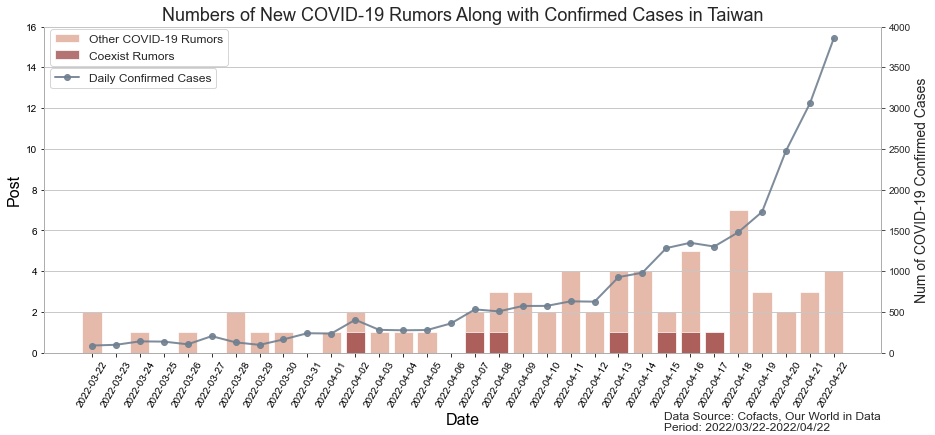

In [29]:
fig, ax = plt.subplots(1,1,figsize=(15,6), facecolor='white', edgecolor='white')
ax.grid()
sns.set_style('whitegrid')

#bar chart
bar1 = sns.barplot(x="createdAt",  y="covid_new_rumor_count", data=new_rumor_count_merge,
                   color='darksalmon', label='Other COVID-19 Rumors', alpha=0.7)
bar2 = sns.barplot(x="createdAt", y="coexist_new_rumor_count", data=new_rumor_count_merge,
                   color='brown', label='Coexist Rumors', alpha=0.7)

top_bar = mpatches.Patch(color='darksalmon')
bottom_bar = mpatches.Patch(color='brown')

plt.legend(handles=[top_bar, bottom_bar])
plt.legend(fontsize = 12, bbox_to_anchor=(0,1.01), loc='upper left')

plt.xticks(rotation=60)
plt.ylabel('Post',fontsize = 16)

ax.set_xlabel('Date', fontsize = 16)
plt.xticks(rotation=60)
ax.set_ylim([0,16])

#line cahrt
ax1= ax.twinx()
x=taiwan['date']
y=taiwan['new_cases']
ax1.plot(x,y,'-o',  color='slategrey', linewidth=2, label='Daily Confirmed Cases', alpha=0.9)

ax1.set_xlabel('Date', fontsize = 16)
ax1.set_ylim([0,4000])
ax1.set_ylabel('Num of COVID-19 Confirmed Cases',fontsize = 14)
ax1.legend(fontsize = 12, bbox_to_anchor=(0,0.89), loc='upper left')


save_name = 'Numbers of New COVID-19 Rumors Along with Confirmed Cases in Taiwan'
plt.title(save_name, fontsize = 18)
plt.annotate('Data Source: Cofacts, Our World in Data\nPeriod: 2022/03/22-2022/04/22', 
             (0.615,0.01), xycoords='figure fraction', fontsize=12)

plt.savefig(pic_path/f'cofacts_{save_name}.png',
            bbox_inches='tight')
plt.show()

# view times: new vs old

In [30]:
all_view = pd.concat([webuser, webwebvisituser, lineuser, linevisit])\
                        [['id', '2022-03-22', '2022-03-23',
                           '2022-03-24', '2022-03-25', '2022-03-26', '2022-03-27', '2022-03-28',
                           '2022-03-29', '2022-03-30', '2022-03-31', '2022-04-01', '2022-04-02',
                           '2022-04-03', '2022-04-04', '2022-04-05', '2022-04-06', '2022-04-07',
                           '2022-04-08', '2022-04-09', '2022-04-10', '2022-04-11', '2022-04-12',
                           '2022-04-13', '2022-04-14', '2022-04-15', '2022-04-16', '2022-04-17',
                           '2022-04-18', '2022-04-19', '2022-04-20', '2022-04-21', '2022-04-22']]

In [31]:
all_view = all_view.groupby(by='id', as_index=False).sum().rename(columns={'id':'article_id'})

In [32]:
covid_all_view = covid_label_data_df[['article_id', 'create_type']].merge(all_view, how='left')

In [33]:
covid_all_view = covid_all_view.drop(columns='article_id').groupby(by='create_type').sum().T

In [34]:
covid_all_view['all_covid_rumor'] = covid_all_view['new_covid_rumor']+covid_all_view['old_covid_rumor']

In [35]:
covid_all_view = covid_all_view.reset_index().rename(columns={'index':'date'})

In [36]:
covid_all_view.head(2)

create_type,date,new_covid_rumor,old_covid_rumor,all_covid_rumor
0,2022-03-22,220,203,423
1,2022-03-23,227,193,420


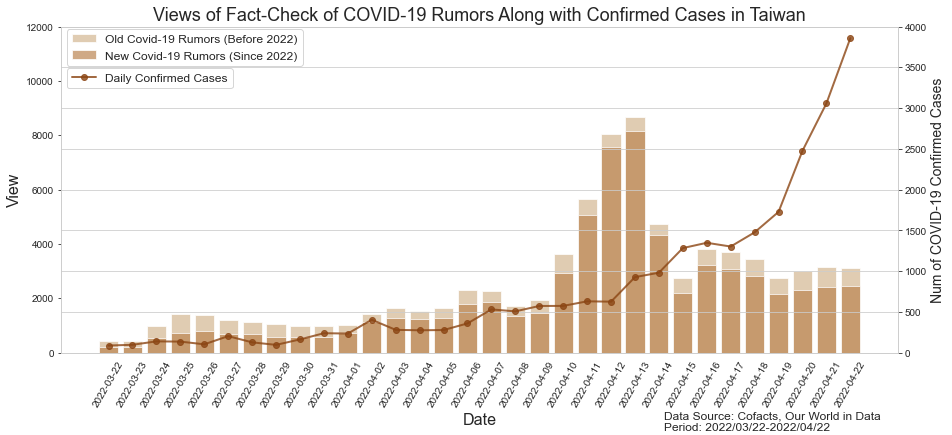

In [37]:
fig, ax = plt.subplots(1,1,figsize=(15,6), facecolor='white', edgecolor='white')
ax.grid()
sns.set_style('whitegrid')

#bar chart
bar1 = sns.barplot(x='date',  y="all_covid_rumor", data=covid_all_view,
                   color='burlywood', label='Old Covid-19 Rumors (Before 2022)', alpha=0.7)
bar2 = sns.barplot(x='date', y="new_covid_rumor", data=covid_all_view,
                   color='peru', label='New Covid-19 Rumors (Since 2022)', alpha=0.7)

top_bar = mpatches.Patch(color='burlywood')
bottom_bar = mpatches.Patch(color='peru')

plt.legend(handles=[top_bar, bottom_bar])
plt.legend(fontsize = 12, bbox_to_anchor=(0,1.01), loc='upper left')

plt.xticks(rotation=60)
plt.ylabel('View',fontsize = 16)

ax.set_xlabel('Date', fontsize = 16)
plt.xticks(rotation=60)
ax.set_ylim([0,12000])

#line cahrt
ax1= ax.twinx()
x=taiwan['date']
y=taiwan['new_cases']
ax1.plot(x,y,'-o',  color='saddlebrown', linewidth=2, label='Daily Confirmed Cases', alpha=0.8)

ax1.set_xlabel('Date', fontsize = 16)
ax1.set_ylim([0,4000])
ax1.set_ylabel('Num of COVID-19 Confirmed Cases',fontsize = 14)
ax1.legend(fontsize = 12, bbox_to_anchor=(0,0.89), loc='upper left')


save_name = 'Views of Fact-Check of COVID-19 Rumors Along with Confirmed Cases in Taiwan'
plt.title(save_name, fontsize = 18)
plt.annotate('Data Source: Cofacts, Our World in Data\nPeriod: 2022/03/22-2022/04/22', 
             (0.615,0.01), xycoords='figure fraction', fontsize=12)

plt.savefig(pic_path/f'cofacts_{save_name}_by_time.png',
            bbox_inches='tight')

plt.show()

# view times: coexist

In [38]:
coexist_all_view = covid_label_data_df[['article_id', 'coexist']].merge(all_view, how='left')

In [39]:
coexist_all_view = coexist_all_view[coexist_all_view.coexist == 'yes']

In [40]:
coexist_all_view = coexist_all_view.drop(columns='article_id').groupby(by='coexist').sum().T

In [41]:
coexist_all_view = coexist_all_view.reset_index().rename(columns={'index':'date', 'yes':'count'})

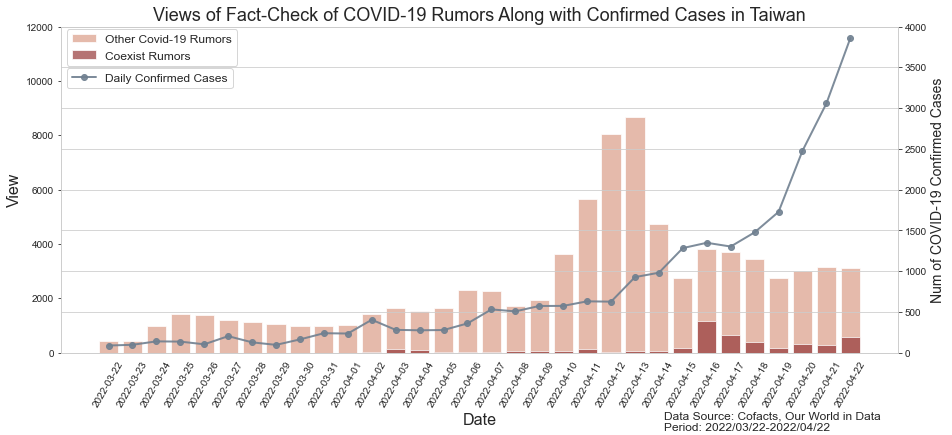

In [42]:
fig, ax = plt.subplots(1,1,figsize=(15,6), facecolor='white', edgecolor='white')
ax.grid()
sns.set_style('whitegrid')

#bar chart
bar1 = sns.barplot(x='date',  y="all_covid_rumor", data=covid_all_view,
                   color='darksalmon', label='Other Covid-19 Rumors', alpha=0.7)
bar2 = sns.barplot(x='date', y="count", data=coexist_all_view,
                   color='brown', label='Coexist Rumors', alpha=0.7)

top_bar = mpatches.Patch(color='darksalmon')
bottom_bar = mpatches.Patch(color='brown')

plt.legend(handles=[top_bar, bottom_bar])
plt.legend(fontsize = 12, bbox_to_anchor=(0,1.01), loc='upper left')

plt.xticks(rotation=60)
plt.ylabel('View',fontsize = 16)

ax.set_xlabel('Date', fontsize = 16)
plt.xticks(rotation=60)
ax.set_ylim([0,12000])

#line cahrt
ax1= ax.twinx()
x=taiwan['date']
y=taiwan['new_cases']
ax1.plot(x,y,'-o',  color='slategrey', linewidth=2, label='Daily Confirmed Cases', alpha=0.9)

ax1.set_xlabel('Date', fontsize = 16)
ax1.set_ylim([0,4000])
ax1.set_ylabel('Num of COVID-19 Confirmed Cases',fontsize = 14)
ax1.legend(fontsize = 12, bbox_to_anchor=(0,0.89), loc='upper left')


save_name = 'Views of Fact-Check of COVID-19 Rumors Along with Confirmed Cases in Taiwan'
plt.title(save_name, fontsize = 18)
plt.annotate('Data Source: Cofacts, Our World in Data\nPeriod: 2022/03/22-2022/04/22', 
             (0.615,0.01), xycoords='figure fraction', fontsize=12)

plt.savefig(pic_path/f'cofacts_{save_name}_by_cat.png',
            bbox_inches='tight')

plt.show()

# particular rumor

In [43]:
particular_rumor_view = all_view.merge(label_data_df[label_data_df['label']==701][['label', 'article_id']])\
                        .drop(columns=['label', 'article_id']).sum()

In [44]:
particular_rumor_view = pd.DataFrame(particular_rumor_view).reset_index()\
                        .rename(columns={'index':'date',0:'count'})

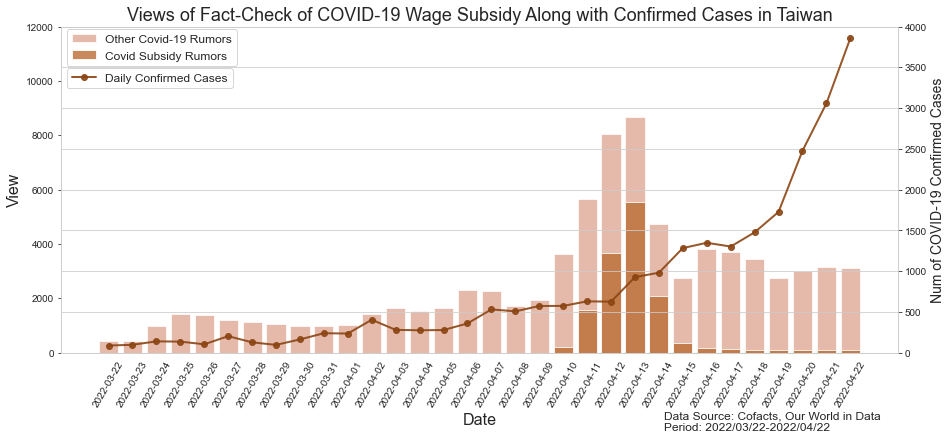

In [45]:
fig, ax = plt.subplots(1,1,figsize=(15,6), facecolor='white', edgecolor='white')
ax.grid()
sns.set_style('whitegrid')

#bar chart
bar1 = sns.barplot(x='date',  y="all_covid_rumor", data=covid_all_view,
                   color='darksalmon', label='Other Covid-19 Rumors', alpha=0.7)
bar2 = sns.barplot(x='date', y="count", data=particular_rumor_view,
                   color='chocolate', label='Covid Subsidy Rumors', alpha=0.8)

top_bar = mpatches.Patch(color='darksalmon')
bottom_bar = mpatches.Patch(color='chocolate')

plt.legend(handles=[top_bar, bottom_bar])
plt.legend(fontsize = 12, bbox_to_anchor=(0,1.01), loc='upper left')

plt.xticks(rotation=60)
plt.ylabel('View',fontsize = 16)

ax.set_xlabel('Date', fontsize = 16)
plt.xticks(rotation=60)
ax.set_ylim([0,12000])

#line cahrt
ax1= ax.twinx()
x=taiwan['date']
y=taiwan['new_cases']
ax1.plot(x,y,'-o',  color='saddlebrown', linewidth=2, label='Daily Confirmed Cases', alpha=0.9)

ax1.set_xlabel('Date', fontsize = 16)
ax1.set_ylim([0,4000])
ax1.set_ylabel('Num of COVID-19 Confirmed Cases',fontsize = 14)
ax1.legend(fontsize = 12, bbox_to_anchor=(0,0.89), loc='upper left')


save_name = 'Views of Fact-Check of COVID-19 Wage Subsidy Along with Confirmed Cases in Taiwan'
plt.title(save_name, fontsize = 18)
plt.annotate('Data Source: Cofacts, Our World in Data\nPeriod: 2022/03/22-2022/04/22', 
             (0.615,0.01), xycoords='figure fraction', fontsize=12)

plt.savefig(pic_path/f'cofacts_{save_name}_by_cat.png',
            bbox_inches='tight')

plt.show()

# correlation coefficient

In [46]:
#每日新增案例
x = np.array(taiwan.new_cases)

In [47]:
#每日fact check view
y = np.array(covid_all_view.all_covid_rumor)

In [48]:
np.corrcoef(x, y)

array([[1.        , 0.34415696],
       [0.34415696, 1.        ]])

# covid/general view proportion

In [49]:
general_rumor_count = all_view.drop(columns='article_id').sum().sum()
print(general_rumor_count)

318047


In [50]:
covid_rumor_count = covid_all_view.all_covid_rumor.sum()
print(covid_rumor_count)

82016


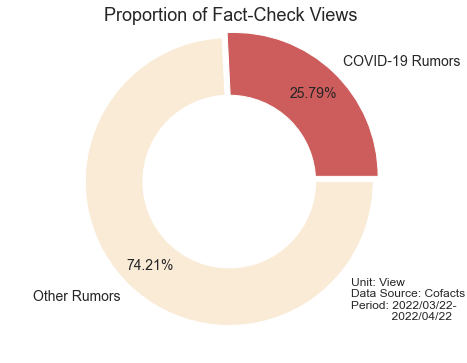

In [51]:
plt.figure(figsize=(8,6), facecolor='white', edgecolor='white')

size_of_groups=[general_rumor_count-covid_rumor_count, covid_rumor_count]
# Create a pie plot
separated = (0, .05)
colors = ['antiquewhite', 'indianred']
labels = ['Other Rumors','COVID-19 Rumors']
plt.pie(size_of_groups, counterclock=False, textprops = {"fontsize" : 14},
        autopct = "%1.2f%%", pctdistance=0.8,
        explode=separated, colors=colors, labels=labels)

# add a white circle at the center
my_circle=plt.Circle((0,0), 0.6, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.axis('equal')

plt.annotate('Unit: View\nData Source: Cofacts\nPeriod: 2022/03/22-\n            2022/04/22', 
             (0.61,0.1), xycoords='figure fraction', fontsize=12)

save_name = 'Proportion of Fact-Check Views'
plt.title(save_name, fontsize = 18, y=0.97)

plt.savefig(pic_path/f'cofacts_{save_name}.png', 
            bbox_inches='tight') # 去除座標軸占用的空間

plt.show()